### Importing Libraries


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
from scipy.stats import shapiro, levene, mannwhitneyu
import warnings
warnings.simplefilter(action='ignore')

### Loading Data


In [3]:
data = pd.read_csv(r'..\data\cookie_cats.csv')

In [7]:
data.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


### Descriptive Statistics


In [6]:
data.isnull().sum()

userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

In [8]:
# Number of unique player
print('Number of Unique Players:', data["userid"].nunique())

Number of Unique Players: 90189


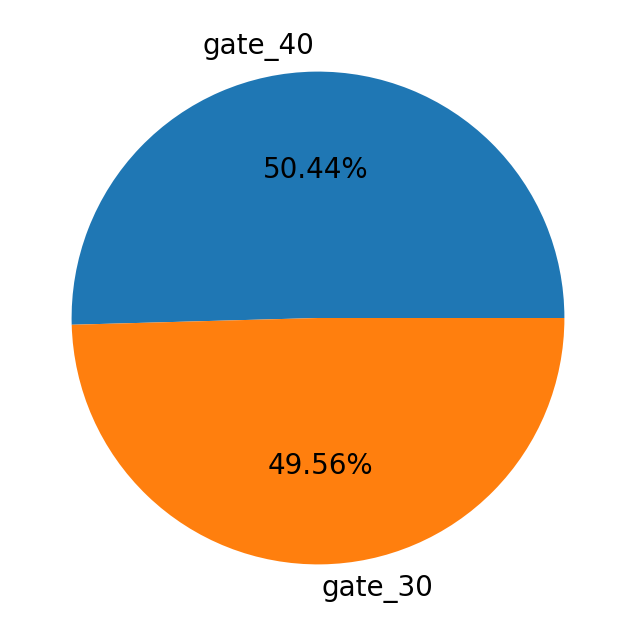

 
OBSERVATION: The number of players in each version is very balanced the data is not very skewed.



In [14]:
import matplotlib.pyplot as plt

# Assuming 'data' is your DataFrame or data source
plt.figure(figsize=(12, 8))

# Create the pie chart with labels and set the font size using 'textprops'
plt.pie(
    x=data['version'].value_counts().values,
    labels=data['version'].value_counts().index,
    autopct='%.2f%%',
    textprops={'fontsize': 20}  # You can adjust the font size (e.g., 14)
)

plt.show()



print(''' 
OBSERVATION: The number of players in each version is very balanced the data is not very skewed.
''')

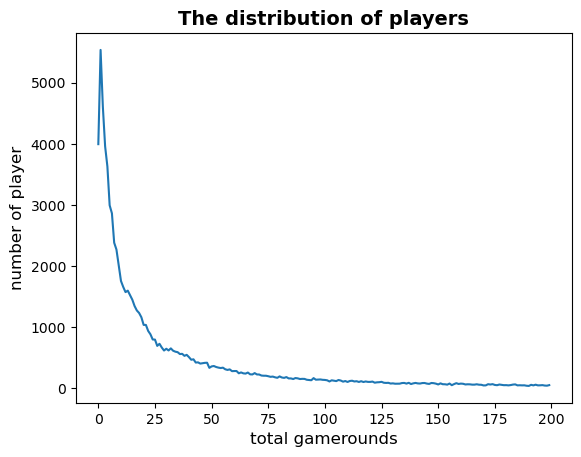

 
    OBSERVATION: In the above plot we can see that some players install the game but then never play it (0 game rounds)
      


In [18]:
# Plotting the distribution of players that played 0 to 200 game rounds
ax = data.groupby("sum_gamerounds")["userid"].count().head(200).plot()
plt.title("The distribution of players", fontweight="bold", size=14)
plt.xlabel("total gamerounds", size=12)
plt.ylabel("number of player", size=12)
plt.show()


print(''' 
    OBSERVATION: In the above plot we can see that some players install the game but then never play it (0 game rounds)
      ''')

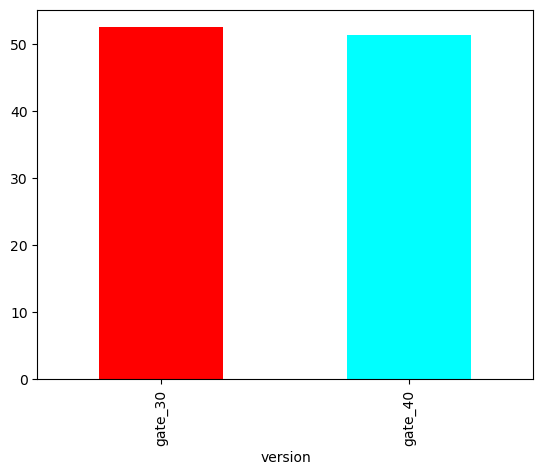

 
    OBSERVATION: the average number of game rounds seems to be more for 'gate30'
      


In [5]:
data.groupby("version")["sum_gamerounds"].mean().plot(kind="bar", color=[ "red", "cyan"])
plt.show()

print(''' 
    OBSERVATION: the average number of game rounds seems to be more for 'gate30'
      ''')

In [16]:
round(data.groupby("version")["sum_gamerounds"].mean(),2)

version
gate_30    52.46
gate_40    51.30
Name: sum_gamerounds, dtype: float64

In [14]:
# Percentage of Players Never Playing the game
print(
    f'The percentage of Players installing the game and never playing it is {round(len(data[data.sum_gamerounds == 0]) / len(data) , 4) * 100}%')

The percentage of Players installing the game and never playing it is 4.43%


In [45]:
#Number of game rounds played by player for each version
data.groupby("version").agg({"sum_gamerounds" : ["mean","max","count"]})

sum_gamerounds              
                  mean    max  count
version                             
gate_30      52.456264  49854  44700
gate_40      51.298776   2640  45489

### A/B Testing

Hypothesis

μ1=gate is at level 30

μ2=gate is at level 40

HO -> The μ1=μ2 (No statistical significance)

H1 -> The μ1!=μ2 (statistical significance)


Assumptions Control

        i.Normal Distribution
        H0 : The assumption of normal distribution is provided.
        H1 : The assumption of normal distribution is not provided.
        p-value < 0.05 => H0 -> Reject
        p-value > 0.05 => H0 -> Cannot Reject

In [71]:
# gate30 
test_stat, pvalue = shapiro(data.loc[data["version"] == "gate_30", "sum_gamerounds"])
print("Test Stat = %.4f, p-value = %.4f" % (test_stat, pvalue))

Test Stat = 0.0881, p-value = 0.0000


In [72]:
# gate40
test_stat, pvalue = shapiro(data.loc[data["version"] == "gate_40", "sum_gamerounds"])
print("Test Stat = %.4f, p-value = %.4f" % (test_stat, pvalue))

Test Stat = 0.4826, p-value = 0.0000


In both cases, p-value = 0. The normality assumption was rejected because it was less than 0.05.

        ii.Variance Homogeneity Assumption
        H0 : The variance is homogeneous.
        H1 : The variance is not homogeneous.
        p-value < 0.05 => H0 -> Reject
        p-value > 0.05 => H0 -> Cannot Reject

In [73]:
test_stat, pvalue = levene(data.loc[data["version"] == "gate_30", "sum_gamerounds"],
                            data.loc[data["version"] == "gate_40", "sum_gamerounds"])
print("Test Stat = %.4f, p-value = %.4f" % (test_stat, pvalue))

Test Stat = 0.5292, p-value = 0.4669


H0 cannot be rejected because the p-value is greater than 0.05. 

If the normality assumption is rejected for the A/B test, but the variance homogeneity assumption is satisfied, then it is recommended to use non-parametric test methods. 

In [74]:
test_stat, pvalue = mannwhitneyu(data.loc[data["version"] == "gate_30", "sum_gamerounds"],
                            data.loc[data["version"] == "gate_40", "sum_gamerounds"])
print("Test Stat = %.4f, p-value = %.4f" % (test_stat, pvalue))

Test Stat = 1024331250.5000, p-value = 0.0502


#### Result

H0 cannot be rejected because the p-value is greater than 0.05

There is no statistically significant difference between 'gate30' and 'gate40' with 95% confidence

Now, we may look to other factors like how to postion of the gate effect retention, that is, is there any statistical significance in retention based on the gates position

### A/B Testing on Retention


In [32]:
# Percentage of Retention for the 1st day and the 7th day after installing the game
df_retention = data[["retention_1", "retention_7"]].mean()*100
print(
    f"1-day retention ratio: {round(df_retention[0],2)}%\n7-days retention ratio: {round(df_retention[1],2)}%")

print('''
OBSERVATION: A little less than half of the players come back one day after installing the game. 
             18% of the players come back 7 day after installing the game.
      ''')

1-day retention ratio: 44.52%
7-days retention ratio: 18.61%

OBSERVATION: A little less than half of the players come back one day after installing the game. 
             18% of the players come back 7 day after installing the game.
      


In [4]:
# Calculating 1-day and 7-days retention for each A/B group
df_retention_ab = data.groupby("version").agg(
    {"userid": "count", "retention_1": "mean", "retention_7": "mean", "sum_gamerounds": "sum"})
df_retention_ab = df_retention_ab.rename(columns={
    "userid": "User Count",
    "retention_1": "1-Day Retention",
    "retention_7": "7-Day Retention",
    "sum_gamerounds": "Total Game Rounds"
})

print(df_retention_ab)


print(''' 
OBSERVATION: 1.There was a slight decrease in 1-day retention when the gate was moved to level 40 (44.2%) compared 
               to the control group when it was at level 30 (44.8%).
             2.A decrease in 7-day retention when the gate was moved to level 40 (18.2%) compared to the control 
               group when it was at level 30 (19.8%).
''')

         User Count  1-Day Retention  7-Day Retention  Total Game Rounds
version                                                                 
gate_30       44700         0.448188         0.190201            2344795
gate_40       45489         0.442283         0.182000            2333530
 
OBSERVATION: 1.There was a slight decrease in 1-day retention when the gate was moved to level 40 (44.2%) compared 
               to the control group when it was at level 30 (44.8%).
             2.A decrease in 7-day retention when the gate was moved to level 40 (18.2%) compared to the control 
               group when it was at level 30 (19.8%).



#### 1. A/B Testing Using Hypothesis

Hypothesis

μ1=retention when gate is at level 30

μ2=retention when gate is at level 40

HO -> The μ1=μ2 (No statstical significance)

H1 -> The μ1!=μ2 (statstical significance)


In [52]:
control = data[data['version'] == 'gate_30'].copy()

control.retention_1 = control.retention_1.replace({True: 1, False: 0})
control.retention_7 = control.retention_7.replace({True: 1, False: 0})

In [58]:
experimental = data[data['version'] == 'gate_40'].copy()

experimental.retention_1 = experimental.retention_1.replace({True: 1, False: 0})
experimental.retention_7 = experimental.retention_7.replace({True: 1, False: 0})

In [59]:
def AB_testing(x1 , x2 ):
    x_bar1 = np.mean(x1)
    var1 = np.var(x1)
    n1 = len(x1)
    
    x_bar2 = np.mean(x2)
    var2 = np.var(x2)
    n2 = len(x2)
    
    z_score = (x_bar1 - x_bar2) / np.sqrt((var1 / n1) + (var2 / n2))
    p_value = st.norm.cdf(z_score)
    if z_score > 0:
        p_value = 2*(1 - p_value)
    else:
        p_value = 2 * p_value
    return print(f'z-score : {z_score} , p-value : {p_value}')

In [60]:
AB_testing(control['retention_7'] , experimental['retention_7'])

z-score : 3.1640640401484066 , p-value : 0.0015558255737109228


In [6]:
test_stat, pvalue = mannwhitneyu(data.loc[data["version"] == "gate_30", "retention_7"],
                            data.loc[data["version"] == "gate_40", "retention_7"])
print("Test Stat = %.4f, p-value = %.4f" % (test_stat, pvalue))

Test Stat = 1025017239.0000, p-value = 0.0016


There is sufficient evidence to declare a difference in the average 7 days retention for the two groups, As the p-value is less than alpha = 0.05 we can reject the null hypothesis at the level of 7 days retention.

In [61]:
AB_testing(control['retention_1'] , experimental['retention_1'])

z-score : 1.7840972718295067 , p-value : 0.07440786052354165


In [5]:
test_stat, pvalue = mannwhitneyu(data.loc[data["version"] == "gate_30", "retention_1"],
                            data.loc[data["version"] == "gate_40", "retention_1"])
print("Test Stat = %.4f, p-value = %.4f" % (test_stat, pvalue))

Test Stat = 1022682813.0000, p-value = 0.0744


Here we can not reject the null hypothese at the level of 1 days retention

#### Result

Percentage of returning players of control group after 7 day is 19.0%, whereas Percentage of returning players of experimental group is 18.2%

Movement of gate to the 40th level affects negatively on numbers of returning players after 7 days

Z-test above confirms that the changes were significant